---

**Assignment 3: Mobility Tracking (Connected Mobility Basics, Winter 2019/20)**

Felix Schorer | Haoyang Sun | Simon Zachau

---

<strong id="tocheading">Table of Contents</strong>

<div id="toc"></div>

In [46]:
%%javascript
// adapted from https://github.com/kmahelona/ipython_notebook_goodies/blob/gh-pages/ipython_notebook_toc.js
var toc = "";
var level = 0;
var levels = {}
$('#toc').html('');

$(":header").each(function(i){
    var titleText = this.innerHTML;
    var openLevel = this.tagName[1];

    if (levels[openLevel]){
        levels[openLevel] += 1;
    } else{
        levels[openLevel] = 1;
    }

    if (openLevel > level) {
        toc += (new Array(openLevel - level + 1)).join('<ul class="toc">');
    } else if (openLevel < level) {
        toc += (new Array(level - openLevel + 1)).join("</ul>");
        for (i=level;i>openLevel;i--){
            levels[i]=0;
        }
    }

    level = parseInt(openLevel);
    
    if (level < 3) {
        if (this.id == ''){
            this.id = this.innerHTML.replace(/ /g,"-")
        }
        var anchor = this.id;

        toc += '<li><a href="#' + encodeURIComponent(anchor) + '">' + titleText + '</a></li>';
    }

});


if (level) {
    toc += (new Array(level + 1)).join("</ul>");
}


$('#toc').append(toc);

<IPython.core.display.Javascript object>

---

In [ ]:
%pip install numpy matplotlib scapy[basic] tqdm tabulate

# 1. Study Design and Reasoning

Our goal is to monitor and analyze the mobility of nearby mobile device users, using Wi-Fi probe requests.
A device sends probe requests more frequently when it is not connected to an access point. This is why it made sense
to choose commutes around Munich as our topic. We collected the Wi-Fi probes with a Raspberry Pi and 2 antennas. 
Specifically, we look at the number of packets and their MAC addresses relative to time, and therefore also location. 
In the beginning, we asked ourselves if we could track devices over multiple days during the time of a route 
and if we can we infer from the data when the train/subway stops.

# 2. Measurements and Experiences

We put the device in a cardboard box while recording, so that it does not cause unease. We observed the general number of the passengers on the trip and also the general district that we are in, i.e. city center, edge of the city, or campus). We had two devices, which we could distribute among the three of us so that data could be recorded efficiently.

In [3]:
from tabulate import tabulate


def list_captures(*captures):
    print(tabulate(captures, headers=('File', 'Description', 'Start Date/Time')))

## 2.1 Route from Kaufering to Garching Forschungszentrum

We measured the route from Kaufering to Garching Forschungszentrum on 3 different days each before Christmas and after Christmas. 
It involves the train until Munich Central Station, the S-Bahn from Munich Central Station to Marienplatz, 
and the U6 from Marienplatz to Garching Forschungszentrum. The fact that our measurements involve multiple days, 
but are conducted at 7:00 AM consistently every morning, gives us the chance to compare the results.

![route from Kaufering to Garching Forschungszentrum](./illustrations/kaufering_garchingforschungzentrum.png)

In [4]:
from captures import commutes

list_captures(*commutes)

File               Description                                        Start Date/Time
-----------------  -------------------------------------------------  -------------------
capture-0-a4.pcap  trip from Kaufering to Garching Forschungszentrum  2019-12-16 07:00:00
capture-1-a4.pcap  trip from Kaufering to Garching Forschungszentrum  2019-12-17 07:00:00
capture-2-a4.pcap  trip from Kaufering to Garching Forschungszentrum  2019-12-18 07:00:00
capture-5-a4.pcap  trip from Kaufering to Garching Forschungszentrum  2020-01-13 07:00:00
capture-6-a4.pcap  trip from Kaufering to Garching Forschungszentrum  2020-01-14 07:00:00
capture-7-a4.pcap  trip from Kaufering to Garching Forschungszentrum  2020-01-20 07:00:00


## 2.2 Round Trip Routes of U2 and U6

On the 19th of December we measured 1 round trip in each the U2 and the U6 at noon. 
Both lines meet in the city center but cross different areas of Munich. 
Different demographics and destinations might enable different observations.
The U2 round trip was measured in two files (stopped at the first destination), whereas 
the U6 round trip was measured in one file. We make them comparable in the preprocessing
section "3.2 Stitching U2 Time Series Together".

![route of U2 and U6](./illustrations/u2u6.png)

In [5]:
from captures import u2_to_messestadt, u2_to_feldmoching, u6_roundtrip

list_captures(u2_to_messestadt, u2_to_feldmoching, u6_roundtrip)

File               Description                                                   Start Date/Time
-----------------  ------------------------------------------------------------  -------------------
capture-3-a4.pcap  U2 trip from Feldmoching to Messestadt Ost                    2019-12-19 12:07:00
capture-4-a4.pcap  U2 trip from Messestadt Ost to Feldmoching                    2019-12-19 13:05:00
capture-2-a1.pcap  U6 round trip Garching Forschungszentrum/Klinikum Großhadern  2019-12-19 12:00:00


## 2.3 Route from Munich Central Station to Dortmund Central Station

On the 24th of December we measured a trip in the ICE from Munich Central Station to Dortmund Central Station. 
We might be able to analyse different devices and device usages compared to subway lines in the city center.

![route from Munich Central Station to Dortmund Central Station](./illustrations/munich_dortmund.png)

In [6]:
from captures import munich_to_dortmund

list_captures(munich_to_dortmund)

File               Description                                                    Start Date/Time
-----------------  -------------------------------------------------------------  -------------------
capture-3-a1.pcap  train trip Munich Central Station to Dortmund Central Station  2019-12-24 07:21:00


# 3. Preprocessing

## 3.1 Parsing Captures

In [7]:
import numpy as np
from tqdm import tqdm
from scapy.all import PcapReader
from scapy.layers.dot11 import Dot11ProbeReq


def parse_mac_from_string(mac):
    return bytes.fromhex(mac.replace(':', ''))


def accumulate(file, *accumulators):
    with PcapReader(file) as reader, tqdm(unit='packets', desc=file) as pbar:
        for packet in reader:
            for accumulator in accumulators:
                accumulator(packet)
            pbar.update()


class TimeSeriesAccumulator(list):
    TYPE = ('timestamp', np.float), ('mac', np.bytes_, 6)
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq):
            timestamp = packet.time
            mac = parse_mac_from_string(packet.addr2)
            self.append((timestamp, mac))
            
    def as_numpy_array(self):
        return np.array(self, dtype=np.dtype([*self.TYPE]))

In [8]:
from captures import all_captures

time_series_data = dict()  # capture -> time series data

for capture in all_captures:
    accumulator = TimeSeriesAccumulator()
    accumulate(capture.filename, accumulator)    
    time_series_data[capture] = accumulator.as_numpy_array()

capture-0-a4.pcap: 57279packets [00:59, 962.11packets/s] 
capture-1-a4.pcap: 67268packets [01:11, 945.60packets/s] 
capture-2-a4.pcap: 59223packets [01:03, 937.98packets/s] 
capture-5-a4.pcap: 67624packets [01:06, 1009.79packets/s]
capture-6-a4.pcap: 100160packets [01:31, 1095.14packets/s]
capture-7-a4.pcap: 82099packets [01:24, 973.95packets/s] 
capture-3-a4.pcap: 28533packets [00:30, 924.08packets/s] 
capture-4-a4.pcap: 29382packets [00:32, 905.51packets/s] 
capture-2-a1.pcap: 70172packets [01:15, 926.04packets/s] 
capture-3-a1.pcap: 189263packets [03:45, 839.01packets/s] 


## 3.2 Fixing timestamps

In [9]:
for capture, time_series in time_series_data.items():
    # timestamps in captures are relative, make them absolute
    timestamp_0 = np.amin(time_series[:]['timestamp'])
    correction = capture.start_date.timestamp() - timestamp_0
    time_series[:]['timestamp'] += correction

## 3.3 Anonymizing MAC Addresses

In [10]:
import struct

device_id_anonymization_table = dict()  # device id -> anonymized device id


@np.vectorize
def anonymize_mac(mac):
    vendor_id, device_id = mac[:3], mac[3:]
    if device_id in device_id_anonymization_table:
        return vendor_id + device_id_anonymization_table[device_id]
    else:
        anonymized_device_id = struct.pack('!I', len(device_id_anonymization_table))[-3:]
        device_id_anonymization_table[device_id] = anonymized_device_id
        return vendor_id + anonymized_device_id
    

for time_series in time_series_data.values():
    time_series[:]['mac'] = anonymize_mac(time_series[:]['mac'])

## 3.4 Stitching U2 Time Series Together

In [11]:
from captures import Capture

u2_roundtrip = Capture(
    filename=None, 
    description='U2 round trip Feldmoching/Messestadt Ost',
    start_date=u2_to_messestadt.start_date
)

time_series_data[u2_roundtrip] = np.append(time_series_data[u2_to_messestadt], time_series_data[u2_to_feldmoching])

# 4. Analysis

We first analyse basic statistic, such as the number of probes per time interval (section 4.1), the inter-contact times of mac addresses (section 4.2), and different vendors (section 4.3) as far as they are not anonymised. We discovered interesting anomalies, which we then analysed in more detail. Namely, our U6 round trip features an interesting spike at its final station Klinikum Großhadern, which lead us to have a deeper look at it in section 4.4. Similarly, we wanted to find out if we could deduct stops from the trip from Munich Central Station to Dortmund Central Station. We achieved this in section 4.5.

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
from captures import make_legend


def plot_line_chart(*data, x_label=None, y_label=None, title=None, x_scale='linear', y_scale='linear'):
    plt.figure(figsize=(18, 6))
    legends = []
    for xs, ys, legend in data:
        plt.plot(xs, ys)
        legends.append(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    plt.title(title)
    plt.legend(legends)
    

def plot_stack_plot(data, x_label=None, y_label=None, title=None, x_scale='linear', y_scale='linear'):
    plt.figure(figsize=(18, 6))
    xs, yss, labels = data
    plt.stackplot(xs, yss, labels=labels, cmap='Set1')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    plt.title(title)
    plt.legend(loc='lower left')

## 4.1 Number of Probes Per Time Interval

In [13]:
import math


def duration(timestamps):
    return np.amax(timestamps) - np.amin(timestamps)


def frequency_count(timestamps, time_interval):
    number_of_intervals = math.ceil(duration(timestamps) / time_interval)
    counts = np.zeros(number_of_intervals)
    rel_timestamps = timestamps - np.amin(timestamps)
    for timestamp in rel_timestamps:
        counts[math.floor(timestamp / time_interval)] += 1
    time = np.arange(0, len(counts) * time_interval, time_interval)
    return time, counts

In [14]:
TIME_INTERVAL = 120


def plot_frequency_counts(*captures, time_interval=TIME_INTERVAL):
    plots = []

    for capture in captures:
        timestamps = time_series_data[capture][:]['timestamp']
        xs, ys = frequency_count(timestamps, time_interval)
        plots.append((xs, ys, make_legend(capture)))

    plot_line_chart(*plots, x_label='time (s)', y_label='number of probes per {}s'.format(time_interval))

### Route from Kaufering to Garching Forschungszentrum

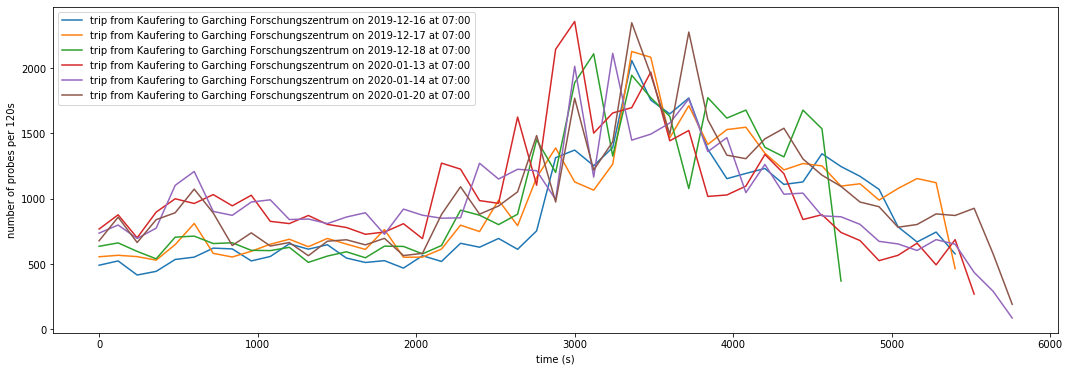

In [15]:
plot_frequency_counts(*commutes)

#### Observations
- The trip on 12/18/2019 (green line) ends early due to the battery running out.
- The change in the number of packets is consistent in relative terms.
- The number of packets per 120s starts at about 500 in Kaufering, grows until Central Station until it reaches 2000 packets per 120s, peaks multiple times around the city center, and decreases until the destination Garching Forschungszentrum.

### Round Trip Routes of U2 and U6

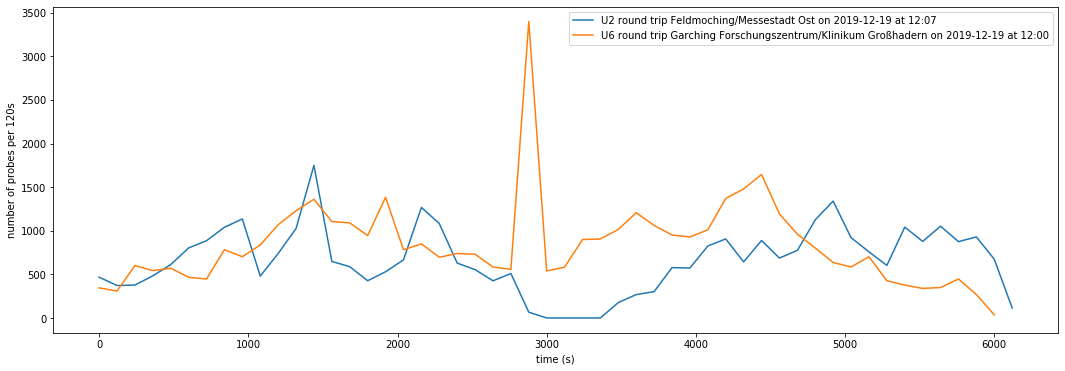

In [16]:
plot_frequency_counts(u2_roundtrip, u6_roundtrip)

#### Observations
- There exists a peak in the U6 measurements right at the final U6 station Klinikum Großhadern. At the U6 station Klinikum Großhadern there is the hospital and eduroam access. We assume that the Raspberry Pi could pick up probes from above the station. The fact that the subway waits for a bit at the final station makes the spike more extreme. We are analysing this spike in more detail in section "4.4 Taking a Closer Look at the Spike in the U6 Data Set".
- Both round trips feature spikes when they come near the city center (at around 1500s and around 4700s), which makes sense as there is a higher number of devices both in the stations and on the subway. Similarly, they feature fewer probe requests at their final stations, except for the peak described in the first bullet point.

### Route from Munich Central Station to Dortmund Central Station

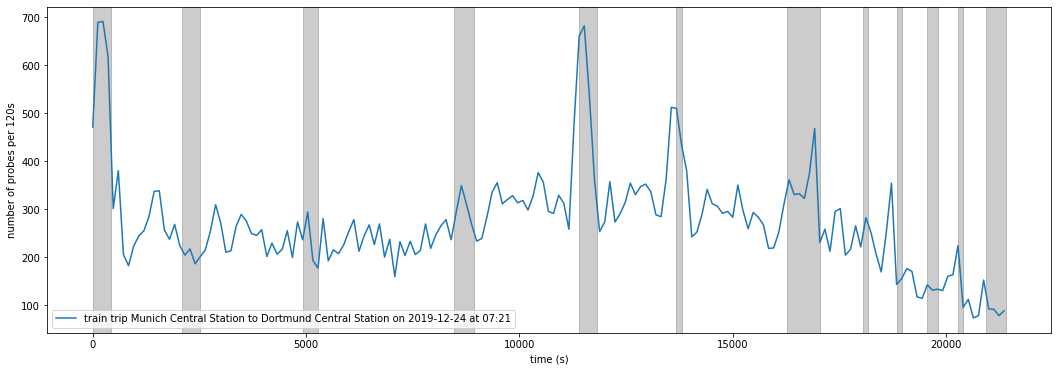

In [97]:
def plot_munich_dortmund_stations():
    stations = ((0, 420),
                (2100, 2520),
                (4920, 5280),
                (8460, 8940),
                (11400, 11820),
                (13680, 13800),
                (16260, 17040),
                (18060, 18180),
                (18840, 18960),
                (19560, 19800),
                (20280, 20400),
                (20940, 21400))

    for start, end in stations:
        plt.axvspan(start, end, color='black', alpha=0.2)


plot_frequency_counts(munich_to_dortmund)
plot_munich_dortmund_stations()

#### Observations
- The packet rate has two peaks, which are clearly above-average: One in Munich Central Station (at 0s) and one in Frankfurt (at about 1200s).
- We highlighted all stations with grey columns. Most of them align with spikes in the packet rate. This means that there are, on average, more probe requests per time unit at train stations compared to other times during the trip. This lead us to the idea to analyse stops based on probes in more detail, which we do in section "4.5 Identifying Stops in the Munich Dortmund Data Set".

## 4.2 Inter-Contact Times of Mac Addresses

In [18]:
from collections import defaultdict


def get_inter_contact_ranges(probes):
    min_max_timestamps = defaultdict(tuple)  # mac -> min, max timestamp
    for probe in probes:
        current_min_max = min_max_timestamps[probe['mac']]
        min_timestamp = min([*current_min_max, probe['timestamp']])
        max_timestamp = max([*current_min_max, probe['timestamp']])
        min_max_timestamps[probe['mac']] = min_timestamp, max_timestamp
    return np.array(list(min_max_timestamps.values()))


def compute_inter_contact_times(inter_contact_ranges):
    return inter_contact_ranges[:, 1] - inter_contact_ranges[:, 0]


def compute_cdf(values):
    total = len(values)
    accumulator = 0
    ys, xs = [], []
    current_value = None
    for value in values:
        if current_value != value and current_value is not None:
            ys.append(accumulator)
            xs.append(current_value)
        current_value = value
        accumulator += 1 / total
    return xs, ys

In [19]:
def plot_inter_contact_times(*captures):
    plots = []

    for capture in captures:
        inter_contact_ranges = get_inter_contact_ranges(time_series_data[capture])
        inter_contact_times = compute_inter_contact_times(inter_contact_ranges)
        xs, ys = compute_cdf(sorted(inter_contact_times))
        plots.append((xs, ys, make_legend(capture)))
    
    plot_line_chart(*plots, x_label='time (s)', y_label='per cent', x_scale='log')

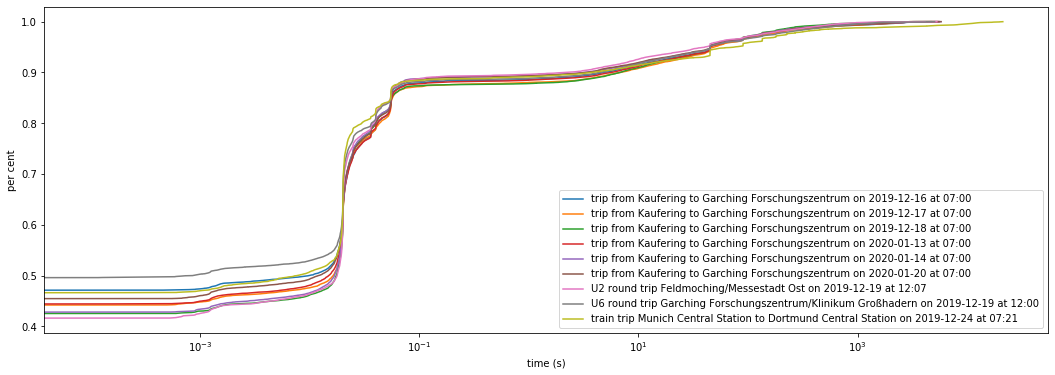

In [20]:
plot_inter_contact_times(*commutes, u2_roundtrip, u6_roundtrip, munich_to_dortmund)

#### Observations
- Almost 90% of MAC addresses are seen for less than 0.1 seconds, probably due to MAC address randomization.
- The above observation is pretty consistent across our datasets.

## 4.3 Vendors

In [ ]:
!wget http://standards-oui.ieee.org/oui/oui.csv

In [22]:
import csv


with open('oui.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    vendors = {bytes.fromhex(row[1]): row[2] for row in reader}


def lookup_vendor(mac):
    return vendors.get(mac[:3], '<randomized>')

In [23]:
from collections import Counter


def vendor_frequency_count(probes, time_interval, top=10):
    total = Counter(lookup_vendor(mac) for mac in probes[:]['mac'])
    ranks = {vendor: index for index, (vendor, _) in enumerate(total.most_common(top))}
    
    timestamps = probes[:]['timestamp']
    number_of_intervals = math.ceil(duration(timestamps) / time_interval)
    counts = np.zeros((top + 1, number_of_intervals))
    min_timestamp = np.amin(timestamps)
    for probe in probes:
        vendor = lookup_vendor(probe['mac'])
        rank = ranks.get(vendor, top)
        rel_timestamp = probe['timestamp'] - min_timestamp
        counts[rank, math.floor(rel_timestamp / time_interval)] += 1
    time = np.arange(0, number_of_intervals * time_interval, time_interval)
    return time, counts, [*ranks.keys(), '<other>']


def compute_vendor_distribution(*args, **kwargs):
    time, counts, labels = vendor_frequency_count(*args, **kwargs)
    return time, counts / np.sum(counts, axis=0), labels

In [24]:
def plot_vendor_distributions(*captures, time_interval=TIME_INTERVAL):
    for capture in captures:
        vendor_distribution = compute_vendor_distribution(time_series_data[capture], time_interval, top=10)
        plot_stack_plot(vendor_distribution, 
                        x_label='time (s)', y_label='percentage of probes per {}s'.format(time_interval), 
                        title=make_legend(capture))

### Route from Kaufering to Garching Forschungszentrum

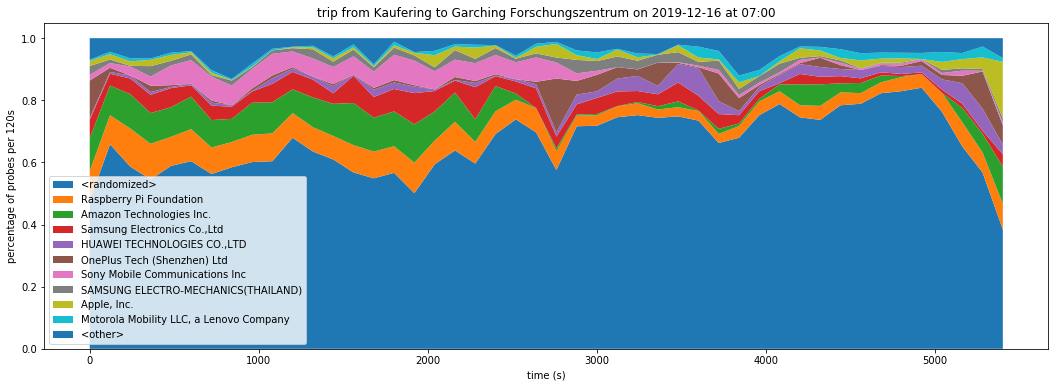

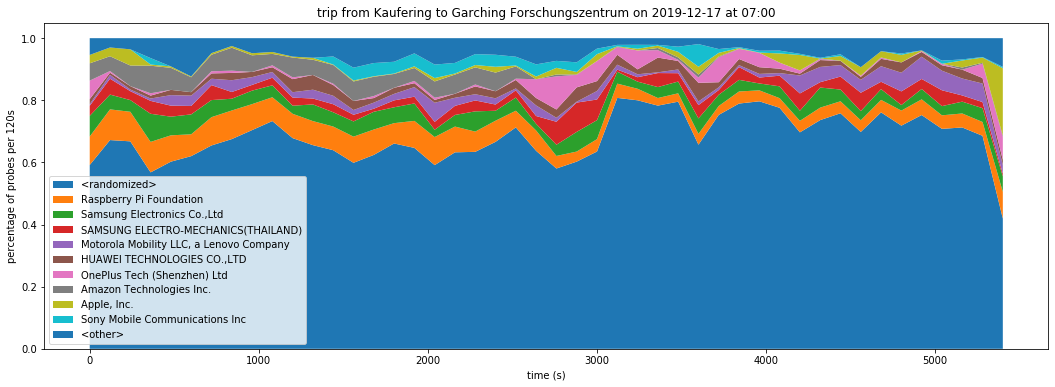

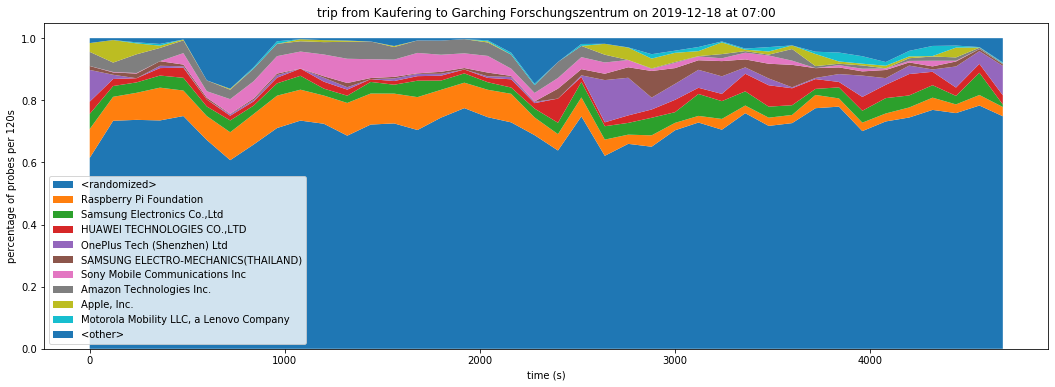

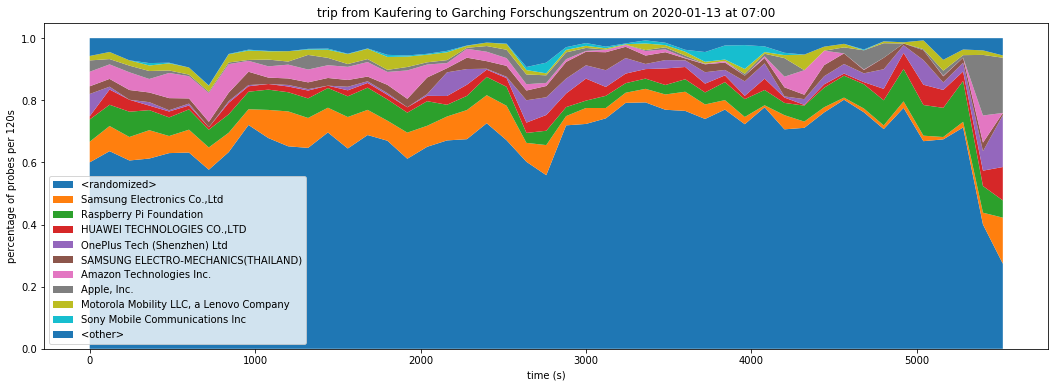

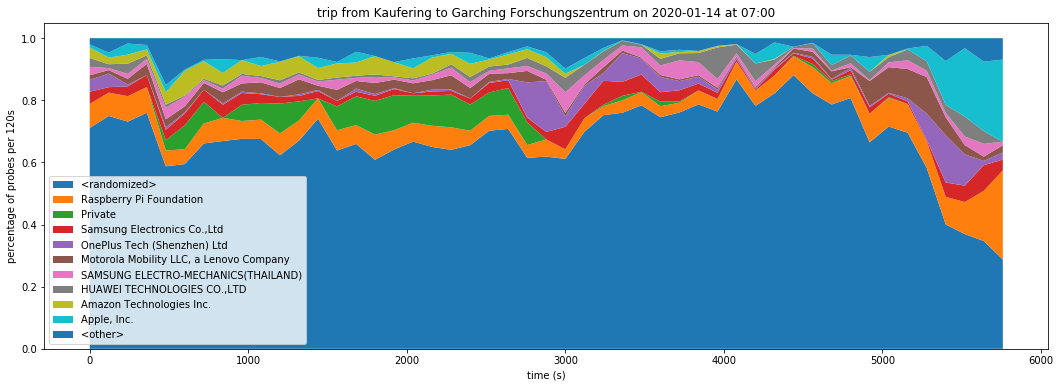

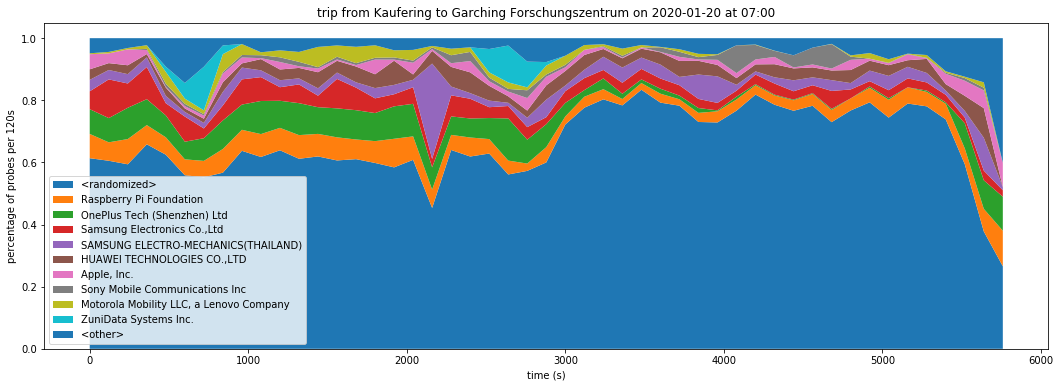

In [25]:
plot_vendor_distributions(*commutes)

#### Observations
- The majority of MAC addresses is randomized.
- The Raspberry Pi is sending probe requests as well.
- The conductor of the measurements owns a OnePlus phone.

### Round Trip Routes of U2 and U6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


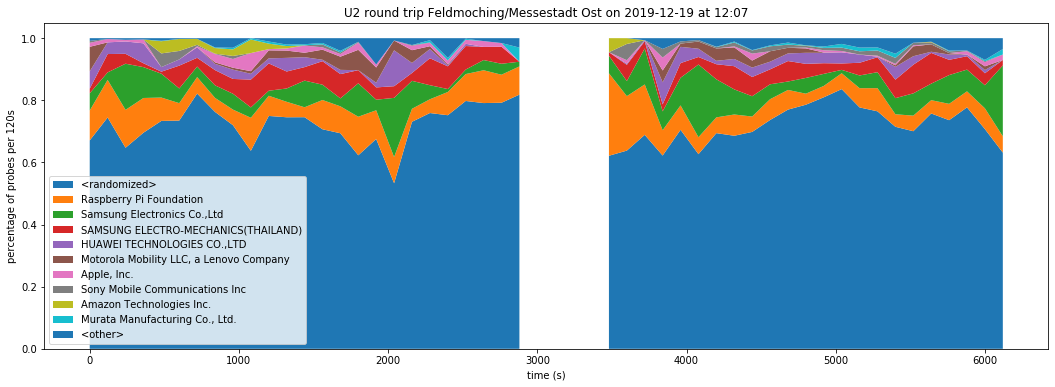

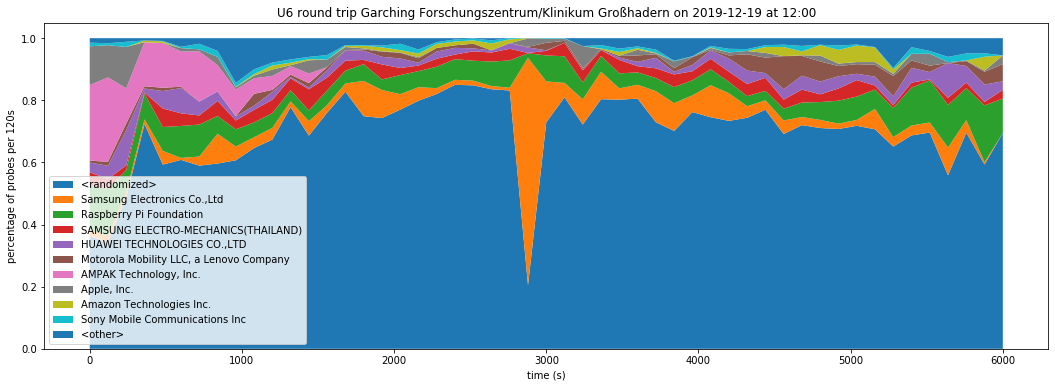

In [26]:
plot_vendor_distributions(u2_roundtrip, u6_roundtrip)

#### Observations
Todo

### Route from Munich Central Station to Dortmund Central Station

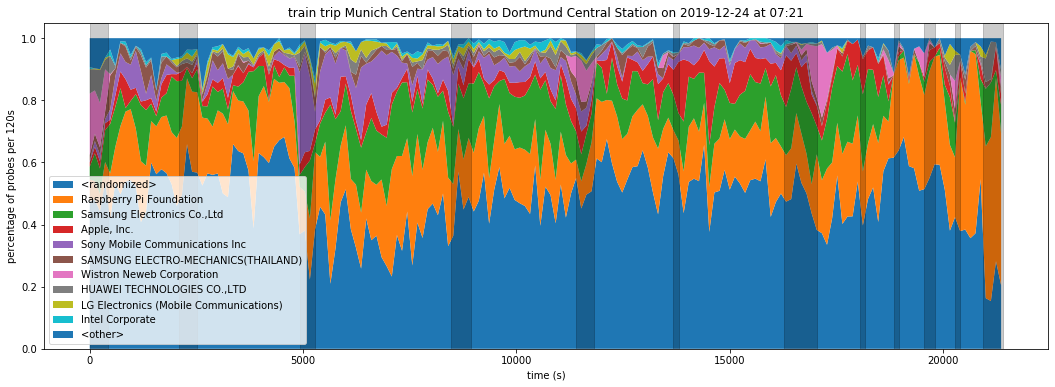

In [98]:
plot_vendor_distributions(munich_to_dortmund)
plot_munich_dortmund_stations()

#### Observations
Todo

## 4.4 Taking a Closer Look at the Spike in the U6 Data Set

In [28]:
def extract_time_range(capture, start_time, end_time):
    timestamps = time_series_data[capture][:]['timestamp']
    timestamp_0 = np.amin(timestamps)
    timestamp_start, timestamp_end = timestamp_0 + start_time, timestamp_0 + end_time
    condition = np.all([timestamp_start <= timestamps, timestamps < timestamp_end], axis=0)
    return time_series_data[capture][condition]


bursts = extract_time_range(u6_roundtrip, 2920, 2950)

In [29]:
def format_mac(mac):
    return ':'.join(bytes([b]).hex() for b in mac)


mac_counts = Counter(bursts[:]['mac']).most_common(5)
table = ((format_mac(mac), lookup_vendor(mac), count) for mac, count in mac_counts)
print(tabulate(table, headers=('MAC Address', 'Vendor', 'Count')))

MAC Address        Vendor                         Count
-----------------  ---------------------------  -------
f0:8a:76:01:ea:ed  Samsung Electronics Co.,Ltd     2459
b8:27:eb:01:cc:10  Raspberry Pi Foundation           10
b0:eb:57:01:d9:fd  HUAWEI TECHNOLOGIES CO.,LTD        9
3c:cd:5d:01:e5:27  HUAWEI TECHNOLOGIES CO.,LTD        9
70:fe:1e:01:eb:06  <randomized>                       9


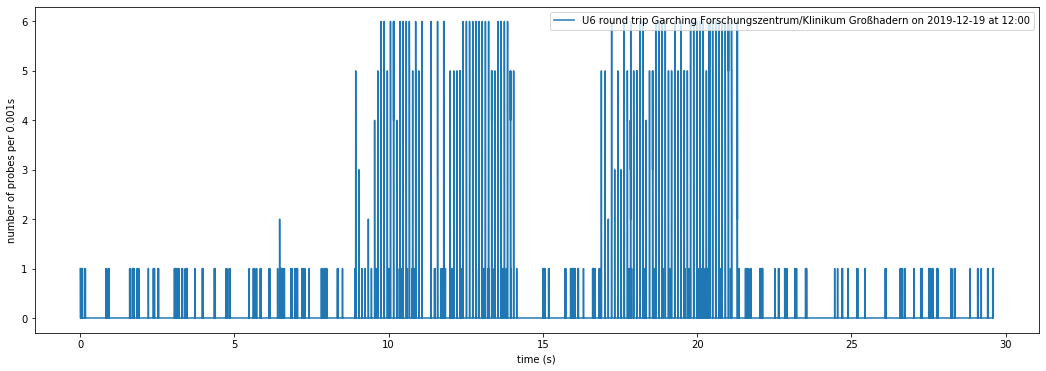

In [30]:
CLOSE_UP_TIME_INTERVAL = 0.001
xs, ys = frequency_count(bursts[:]['timestamp'], CLOSE_UP_TIME_INTERVAL)
plot_line_chart((xs, ys, make_legend(u6_roundtrip)), 
                x_label='time (s)', 
                y_label='number of probes per {}s'.format(CLOSE_UP_TIME_INTERVAL))

#### Observations
Todo

## 4.5 Identifying Stops in the Munich Dortmund Data Set

In [34]:
inter_contact_ranges = get_inter_contact_ranges(time_series_data[munich_to_dortmund])
# only consider contact times of >10 minutes
filtered = inter_contact_ranges[compute_inter_contact_times(inter_contact_ranges) > 600]
timestamp_0 = np.amin(filtered)

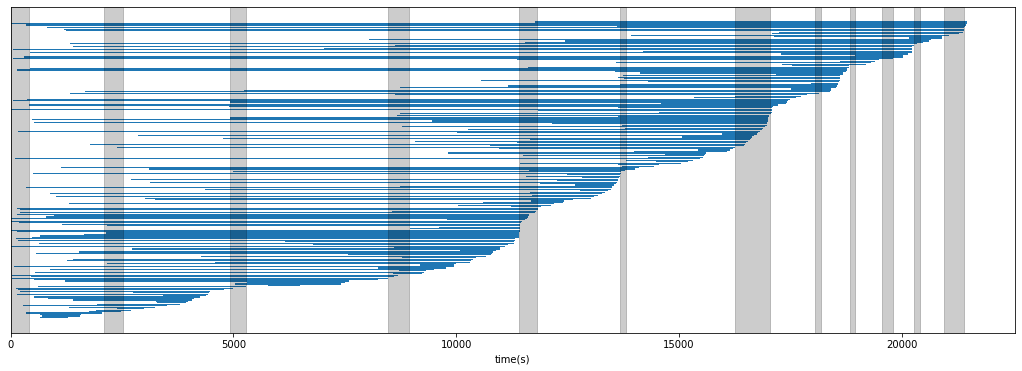

In [99]:
sorted_by_last_seen = filtered[filtered[:, 1].argsort()]
inter_contact_times = compute_inter_contact_times(sorted_by_last_seen)
left_alignment = sorted_by_last_seen[:, 0] - timestamp_0

plt.figure(figsize=(18, 6))
plt.barh(range(len(sorted_by_last_seen)), inter_contact_times, left=left_alignment)
plt.yticks([], [])
plt.xlabel('time(s)')
plot_munich_dortmund_stations()

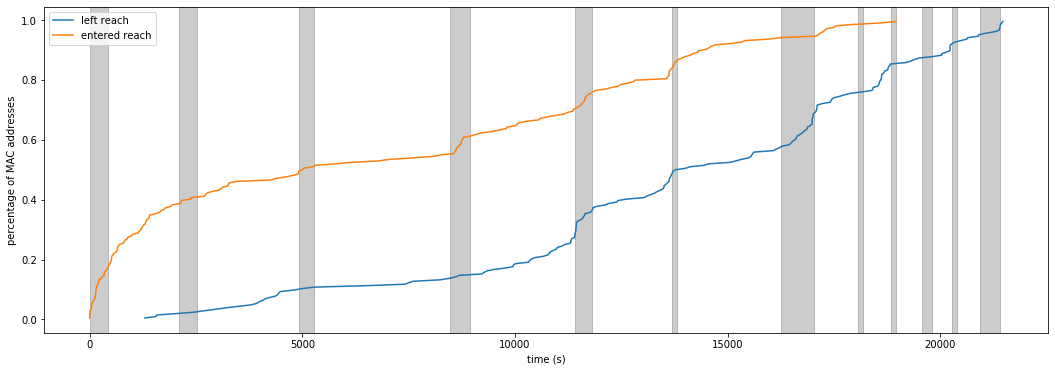

In [100]:
enter_reach = compute_cdf(filtered[:, 0] - timestamp_0)
leave_reach = compute_cdf(np.sort(filtered[:, 1] - timestamp_0))

plt.figure(figsize=(18, 6))
plt.plot(*leave_reach)
plt.plot(*enter_reach)
plt.legend(('left reach', 'entered reach'))
plt.xlabel('time (s)')
plt.ylabel('percentage of MAC addresses')
plot_munich_dortmund_stations()